In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
connection = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

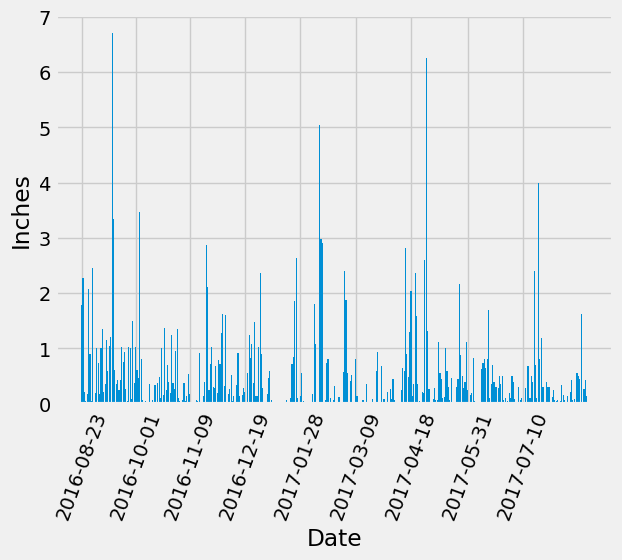

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores  (Did not work - filter(Measurement.date < recent_date, Measurement.date >= query_date).all())
precipitation = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date <= dt.date(2017, 8, 23), Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precipitation, columns=['Precipitation','Date'])

# Sort the dataframe by date
precip_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data 
ticks = ['2016-08-23','2016-10-01','2016-11-09','2016-12-19','2017-01-28','2017-03-09','2017-04-18','2017-05-31','2017-07-10']
plt.bar(precip_df['Date'], precip_df['Precipitation'])
plt.xticks(ticks, rotation=70)
plt.xlabel('Date')
plt.ylabel('Inches')

plt.show()

In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(func.distinct(Measurement.station))).scalar()
stations

9

In [50]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [66]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
active_temps

[(54.0, 85.0, 71.66378066378067)]

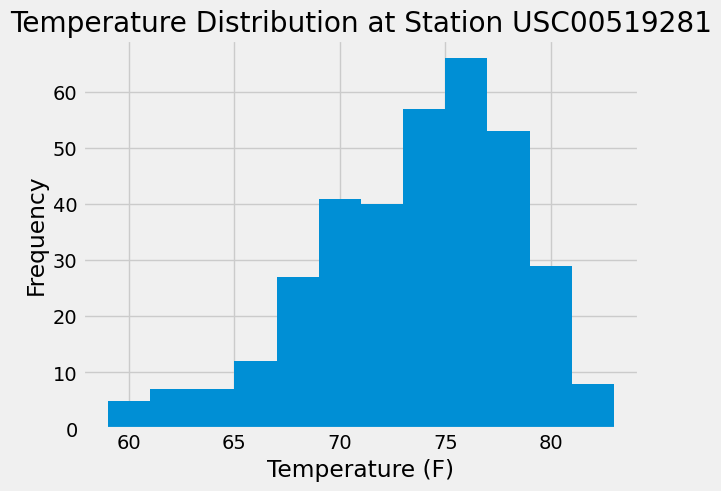

In [99]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
            filter(Measurement.date <= dt.date(2017, 8, 23),
                   Measurement.date >= query_date,
                   Measurement.station == 'USC00519281').all()

temp_data_df = pd.DataFrame(temp_data, columns=['Temp'])
temp_data_df

plt.hist(temp_data_df['Temp'], bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Distribution at Station USC00519281')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()